En esta v2 simplemente he añadido una capa lineal más entre la capa lstm y la capa lineal de salida. Quedaría probar si un dropout me cambia en algo

In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD,AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_mt as rrnn
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)
tasks = ['to','as','about']

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_rrnn(convai_train,['about','to','as'],word_to_index) 
convai_val_token = generic.tokenize_dataset_rrnn(convai_val,['about','to','as'],word_to_index) 

In [6]:
convai_train_dataset =rrnn.DatasetMultiTaskSimple(convai_train_token,tasks,eval=False)

In [7]:
convai_val_dataset = rrnn.DatasetMultiTaskSimple(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_rrnn(md_data,['about','to','as'],word_to_index) 


md_dataset  = rrnn.DatasetMultiTaskSimple(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =  DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)
dl_val = DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)
dl_eval  = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn)

# MultiTask SGD

In [11]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [12]:
model = rrnn.MultiTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_multi_sgd'

In [13]:
print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.4810606060606061, 'as': 0.48370273794002605, 'about': 0.5102040816326531}
Accuracy evaluando en etiquetas female
{'to': 1.0, 'as': 0.9973045822102425, 'about': 1.0}
Accuracy evaluando en etiquetas male
{'to': 0.0, 'as': 0.0025252525252525255, 'about': 0.0}


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0803643651955634 	 Validation loss: 2.0793403164815096 	 
  1%|          | 574/57400 [00:05<07:56, 119.28it/s]
Epoch 2 	 Training loss: 2.077473421545394 	 Validation loss: 2.0800128144732977 	 
  2%|▏         | 1148/57400 [00:10<07:37, 123.01it/s]
Epoch 3 	 Training loss: 2.076287329819975 	 Validation loss: 2.0802332546751376 	 
  3%|▎         | 1722/57400 [00:15<07:23, 125.54it/s]
Epoch 4 	 Training loss: 2.076133737165338 	 Validation loss: 2.0807040060980846 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:20<07:12, 127.28it/s]
Epoch 5 	 Training loss: 2.0759270041661813 	 Validation loss: 2.0808647244663563 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:25<07:10, 126.55it/s]
Epoch 6 	 Training loss: 2.0756812432086424 	 Validation loss: 2.0813243146670066 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:29<06:41, 134.27it/s]
Epoch 7 	 Training loss: 2.075405606824762 	 Validation loss: 2.080792920064118 	 


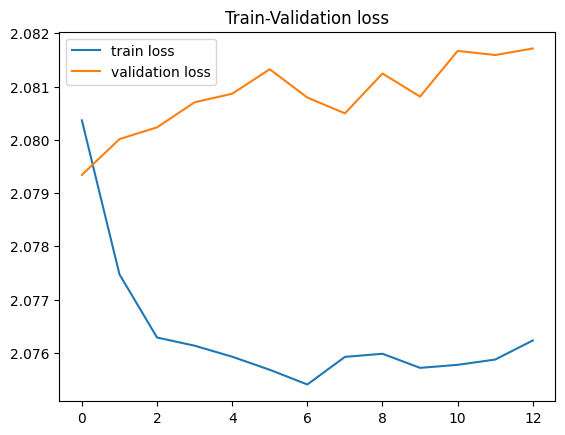

In [14]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [15]:
model = rrnn.MultiTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.5214646464646465, 'as': 0.5228161668839635, 'about': 0.48596938775510207}
Accuracy evaluando en etiquetas female
{'to': 0.03937007874015748, 'as': 0.05121293800539083, 'about': 0.0275}
Accuracy evaluando en etiquetas male
{'to': 0.9683698296836983, 'as': 0.9646464646464646, 'about': 0.9635416666666666}


# AdamW

In [16]:
model = rrnn.MultiTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_multi_adamw'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.075826116555244 	 Validation loss: 2.0812666618217857 	 
  1%|          | 574/57400 [00:05<08:34, 110.49it/s]
Epoch 2 	 Training loss: 2.073845778192793 	 Validation loss: 2.0795846470331742 	 
  2%|▏         | 1148/57400 [00:11<08:29, 110.40it/s]
Epoch 3 	 Training loss: 2.0703362421706992 	 Validation loss: 2.074846869808132 	 
  3%|▎         | 1722/57400 [00:16<08:15, 112.33it/s]
Epoch 4 	 Training loss: 2.067095810943364 	 Validation loss: 2.072924537173772 	 
  4%|▍         | 2296/57400 [00:22<08:11, 112.09it/s]
Epoch 5 	 Training loss: 2.065446422490509 	 Validation loss: 2.0686801490137134 	 
  5%|▌         | 2870/57400 [00:27<08:09, 111.34it/s]
Epoch 6 	 Training loss: 2.063266361631998 	 Validation loss: 2.070373325024621 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:32<08:03, 111.58it/s]
Epoch 7 	 Training loss: 2.0614801055462935 	 Validation loss: 2.066296941142971 	 
  7%|▋         | 4018/57400 [00:38<08:06, 109.74it/s]
Epoch 8 

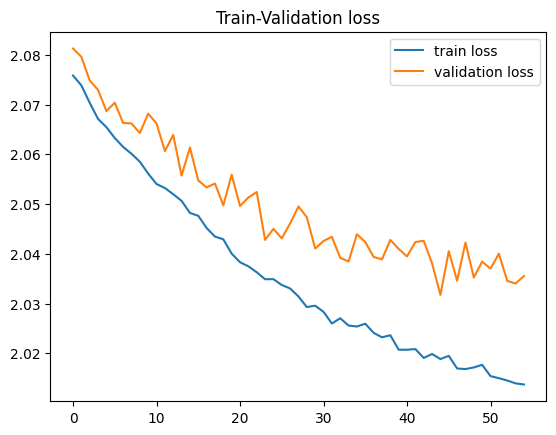

In [17]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [18]:
model = rrnn.MultiTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.5416666666666666, 'as': 0.5671447196870926, 'about': 0.6288265306122449}
Accuracy evaluando en etiquetas female
{'to': 0.32020997375328086, 'as': 0.32075471698113206, 'about': 0.42}
Accuracy evaluando en etiquetas male
{'to': 0.7469586374695864, 'as': 0.797979797979798, 'about': 0.8463541666666666}
